In [9]:
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction
import scipy
import numpy as np

In [10]:
df = pd.read_csv("translations.csv")

# Suppression des doublons dans l'ensemble du DataFrame
df_no_duplicates = df.drop_duplicates()
df_no_duplicates_subset = df.drop_duplicates(subset=['en', 'pl'])
df.drop_duplicates(inplace=True)
df_no_duplicates_reset_index = df_no_duplicates.reset_index(drop=True)
df.to_csv("translations_cleaned.csv", index=False)

In [11]:
df_original = pd.read_csv("translations.csv")
df_cleaned = pd.read_csv("translations_cleaned.csv")

# Comparaison du contenu des deux DataFrames
if df_original.equals(df_cleaned):
    print("Le fichier n'a pas changé.")
else:
    print("Le fichier a été modifié.")

Le fichier n'a pas changé.


In [12]:
df = pd.read_csv("translations.csv")

# Division des données en ensembles de formation et de test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Enregistrement des ensembles d'entraînement et de test dans des fichiers CSV
train_df.to_csv('train_translations.csv', index=False, encoding='utf-8')
test_df.to_csv('test_translations.csv', index=False, encoding='utf-8')

Corrélation entre les longueurs de texte en anglais et en polonais pour train_translations.csv: 0.020713946904087118
P-value pour la corrélation : 0.8454808049673075


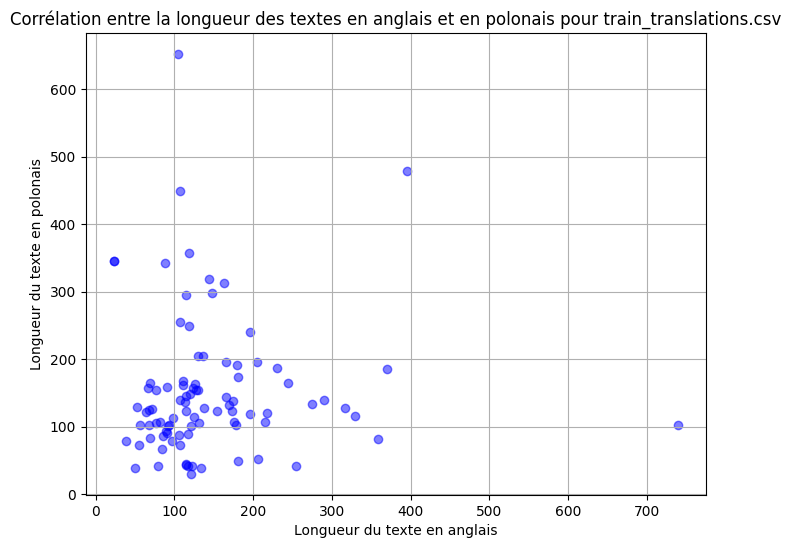

Corrélation entre les longueurs de texte en anglais et en polonais pour test_translations.csv: 0.48006584961406107
P-value pour la corrélation : 0.020430130237907136


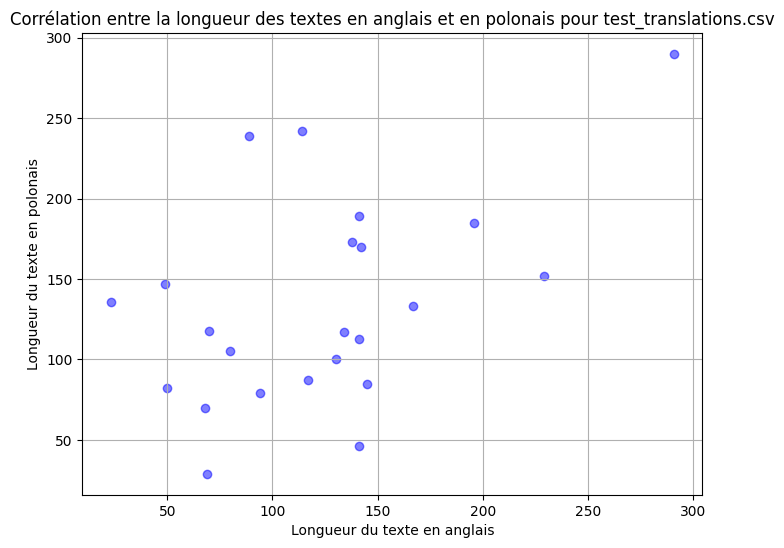

In [13]:
# Fonction de calcul et d'affichage des corrélations
def analyze_correlation(file_path):
    df = pd.read_csv(file_path)

    # Calcul de la longueur des textes en anglais (en) et en polonais (pl)
    df['en_length'] = df['en'].str.len()
    df['pl_length'] = df['pl'].str.len()

    # Calcul de la corrélation entre les longueurs des textes anglais et polonais
    correlation, p_value = pearsonr(df['en_length'], df['pl_length'])

    print(f"Corrélation entre les longueurs de texte en anglais et en polonais pour {file_path}: {correlation}")
    print(f"P-value pour la corrélation : {p_value}")

    # Affichage d'un diagramme de dispersion des longueurs de texte
    plt.figure(figsize=(8, 6))
    plt.scatter(df['en_length'], df['pl_length'], color='blue', alpha=0.5)
    plt.title(f'Corrélation entre la longueur des textes en anglais et en polonais pour {file_path}')
    plt.xlabel('Longueur du texte en anglais')
    plt.ylabel('Longueur du texte en polonais')
    plt.grid(True)
    plt.show()

# Analyse de l'ensemble train
analyze_correlation('train_translations.csv')

# Analyse de l'ensemble test
analyze_correlation('test_translations.csv')

Correlation for train_translations.csv: 0.2426; p-value: 0.0212


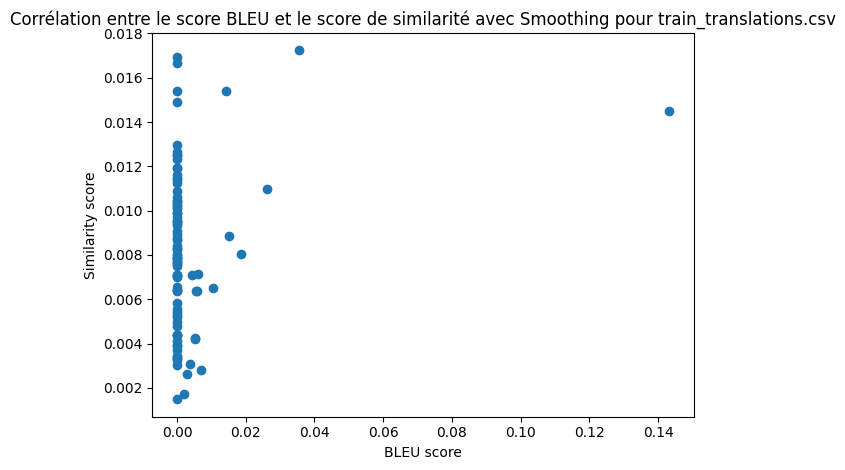

Correlation for test_translations.csv: -0.2961; p-value: 0.1700


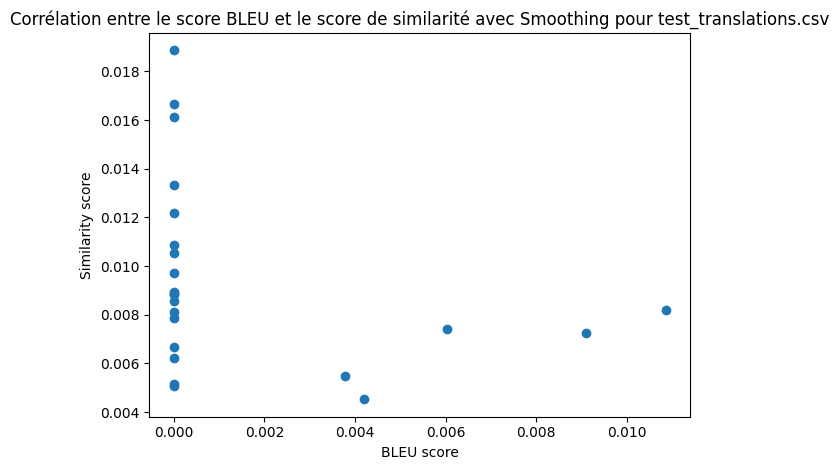

In [14]:
# Fonction permettant de calculer la similarité des résultats sur la base de la distance de Levenshtein
def similarity_score(reference, translation):
    distance = nltk.edit_distance(reference, translation)
    similarity = 1 / (1 + distance)
    return similarity

# Fonction permettant de supprimer les valeurs aberrantes d'un DataFrame
def remove_outliers_df(df, column_name):
    mean = df[column_name].mean()
    std_dev = df[column_name].std()
    threshold = 3 * std_dev
    lower_bound = mean - threshold
    upper_bound = mean + threshold
    df_no_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_no_outliers

# Fonction permettant de calculer le score BLEU et le score de similarité et d'afficher les corrélations
def analyze_bleu_similarity(file_path):
    data = pd.read_csv(file_path)

    # Ajout d'une colonne avec la similarité des résultats au DataFrame
    data['Similarity_score'] = data.apply(lambda row: similarity_score(row['en'], row['pl']), axis=1)

    # Suppression des valeurs aberrantes du DataFrame pour assurer la similarité des résultats
    data_no_outliers = remove_outliers_df(data, 'Similarity_score')

    # Calcul du score BLEU à l'aide de la fonction de smoothing
    bleu_scores = []
    smooth_func = SmoothingFunction().method1
    for idx, row in data_no_outliers.iterrows():
        reference = row['en'].split()
        translation = row['pl'].split()
        bleu_score = bleu.sentence_bleu([reference], translation, smoothing_function=smooth_func)
        bleu_scores.append(bleu_score)

    # Corrélation et p-value
    corr, p = scipy.stats.pearsonr(bleu_scores, data_no_outliers['Similarity_score'])
    print(f"Correlation for {file_path}: {corr:.4f}; p-value: {p:.4f}")

    # Diagramme de dispersion
    plt.scatter(bleu_scores, data_no_outliers['Similarity_score'])
    plt.xlabel("BLEU score")
    plt.ylabel("Similarity score")
    plt.title(f"Corrélation entre le score BLEU et le score de similarité avec Smoothing pour {file_path}")
    plt.tight_layout()
    plt.show()

analyze_bleu_similarity('train_translations.csv')

analyze_bleu_similarity('test_translations.csv')